# Implementation of Conditional VAE

### Environment
* torch==1.9.0+cu111
* scikit-learn==0.24.2
* numpy==1.19.5


In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.manifold import TSNE


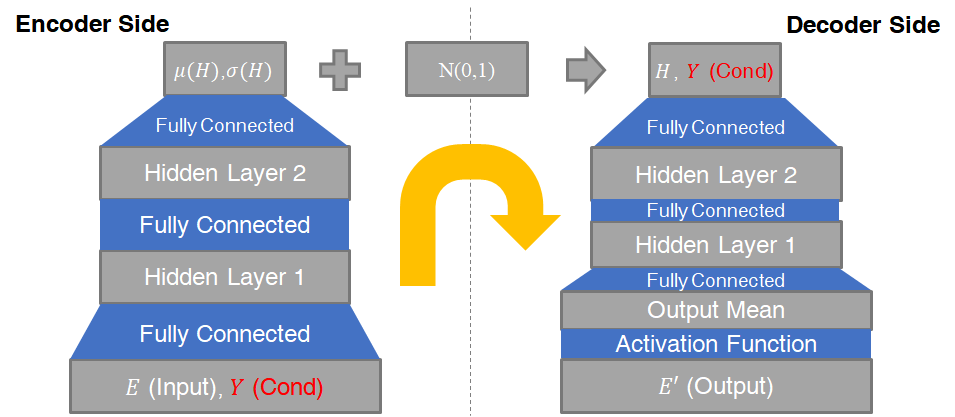


### Task 1. Implement CVAE
The above is the structure of CVAE. The below is the skeleton code for your implementation.

* **def __init__(self,network_architecture,transfer_fct=torch.sigmoid):** ***network_architecture*** is the list of neural network configurations, and ***transfer_fct*** is the activation function selection
* **def train(self,train_loader,batch_size=100,training_epochs=500,learning_rate=0.0005):** ***train_loader*** will be given from the skeleton code by loading the MNIST in the below.
* **def plotReconstructTest(self,intNum,lstLatent,strFileName):** ***intNum*** is the number to synthesize the image, which should be either 0,1...9. ***lstLatent*** is the two dimensional list designating the latent embedding position, which will be chosen arbitrarility. ***strFilename*** is the filename to save the generated image.
* **def plotScatter2D(self,testDataFeature,testDataClass,strFileName):** ***testDataFeature*** is the list of data features from the test dataset, i.e. MNIST, ***testDataClass*** is the class indicator/label of the test dataset, ***strFileName*** is the file to save the scatter plot.


The inside of the above methods are free to be altered. Also, you are free to add additional methods and variabels.

In [2]:
class CVariationalAutoEncoder(torch.nn.Module):

    network_architecture = []  # network_architecture : 인공신경망의 구조를 저장
    all_weights = {}
    transfer_fct = 0

    x = []  # x : VAE의 Input
    x_reconstr_mean = []  # x_reconstr_mean : VAE의 Output
    z = []  # z : VAE의 latent variable
    z_mean = []  # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = []  # z_log_sigma_sq : VAE의 latent variable의 log sigma sq

    cost = 0
    optimizer = 0

    learning_rate = 0
    network_weights = {}

    def __init__(self, network_architecture, transfer_fct=torch.sigmoid):
        super(CVariationalAutoEncoder, self).__init__()
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct  # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정

    def _initialize_weights(
        self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z, class_size
    ):
        torch.set_default_dtype(torch.double)

        self.all_weights["weights_recog"] = {
            "h1": torch.nn.Parameter(self.xavier_init(n_input + class_size, n_hidden_recog_1), requires_grad=True),
            "h2": torch.nn.Parameter(self.xavier_init(n_hidden_recog_1, n_hidden_recog_2), requires_grad=True),
            "out_mean": torch.nn.Parameter(self.xavier_init(n_hidden_recog_2, n_z), requires_grad=True),
            "out_log_sigma": torch.nn.Parameter(self.xavier_init(n_hidden_recog_2, n_z), requires_grad=True),
        }

        self.all_weights["biases_recog"] = {
            "b1": torch.nn.Parameter(torch.zeros([n_hidden_recog_1]), requires_grad=True),
            "b2": torch.nn.Parameter(torch.zeros([n_hidden_recog_2]), requires_grad=True),
            "out_mean": torch.nn.Parameter(torch.zeros([n_z]), requires_grad=True),
            "out_log_sigma": torch.nn.Parameter(torch.zeros([n_z]), requires_grad=True),
        }

        self.all_weights["weights_gener"] = {
            "h1": torch.nn.Parameter(self.xavier_init(n_z + class_size, n_hidden_gener_1), requires_grad=True),
            "h2": torch.nn.Parameter(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2), requires_grad=True),
            "out_mean": torch.nn.Parameter(self.xavier_init(n_hidden_gener_2, n_input), requires_grad=True),
            "out_log_sigma": torch.nn.Parameter(self.xavier_init(n_hidden_gener_2, n_input), requires_grad=True),
        }

        self.all_weights["biases_gener"] = {
            "b1": torch.nn.Parameter(torch.zeros([n_hidden_gener_1]), requires_grad=True),
            "b2": torch.nn.Parameter(torch.zeros([n_hidden_gener_2]), requires_grad=True),
            "out_mean": torch.nn.Parameter(torch.zeros([n_input]), requires_grad=True),
            "out_log_sigma": torch.nn.Parameter(torch.zeros([n_input]), requires_grad=True),
        }
        return self.all_weights

    def forward(self, x, y):
        self.x = x
        # recognition network
        weights, biases = self.all_weights["weights_recog"], self.all_weights["biases_recog"]
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(weights, biases, x, y)

        # reparameterization
        self.z = self._reparameterization(self.z_mean, self.z_log_sigma_sq)

        # generator network
        weights, biases = self.all_weights["weights_gener"], self.all_weights["biases_gener"]
        self.x_reconstr_mean = self._generator_network(weights, biases, self.z, y)

        reconstr_loss = -torch.sum(
            x * torch.log(1e-10 + self.x_reconstr_mean) + (1 - x) * torch.log(1e-10 + 1 - self.x_reconstr_mean), 1
        )
        latent_loss = -0.5 * torch.sum(
            1 + self.z_log_sigma_sq - torch.square(self.z_mean) - torch.exp(self.z_log_sigma_sq), 1
        )

        self.cost = torch.mean(reconstr_loss + latent_loss)
        return self.cost

    def _recognition_network(self, weights, biases, x=None, y=None):

        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        xy = torch.cat([x, y], 1)
        layer_1 = self.transfer_fct(torch.add(torch.matmul(xy, weights["h1"]), biases["b1"]))  # L1 = g(b1 + W1*X)
        layer_2 = self.transfer_fct(
            torch.add(torch.matmul(layer_1, weights["h2"]), biases["b2"])
        )  # L2 = g(b2 + W2*L1)

        z_mean = torch.add(
            torch.matmul(layer_2, weights["out_mean"]), biases["out_mean"]
        )  # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = torch.add(torch.matmul(layer_2, weights["out_log_sigma"]), biases["out_log_sigma"])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases, z=None, y=None):
        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean

        zy = torch.cat([z, y], 1)
        layer_1 = self.transfer_fct(torch.add(torch.matmul(zy, weights["h1"]), biases["b1"]))  # L1 = g(b1 + W1*Z)
        layer_2 = self.transfer_fct(
            torch.add(torch.matmul(layer_1, weights["h2"]), biases["b2"])
        )  # L2 = g(b2 + W2*L1)
        x_reconstr_mean = torch.sigmoid(torch.add(torch.matmul(layer_2, weights["out_mean"]), biases["out_mean"]))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2
        return x_reconstr_mean

    def _reparameterization(self, z_mean, z_log_sigma_sq):
        # Z mean과 Z sigma를 이용해 Z를 reparameterize하는 method
        # Input : z_mean, z_log_sigma_sq
        # Output : z

        n_z = self.network_architecture["n_z"]
        n_batch = len(z_log_sigma_sq)
        eps = torch.normal(mean=0, std=1, size=(n_batch, n_z), dtype=torch.double)

        z = torch.add(z_mean, torch.mul(torch.sqrt(torch.exp(z_log_sigma_sq)), eps))

        return z

    def get_weights(self):
        # Training될 weight를 모두 반환하는 method

        weights = []
        weights.append(self.all_weights["weights_recog"]["h1"])
        weights.append(self.all_weights["biases_recog"]["b1"])
        weights.append(self.all_weights["weights_recog"]["h2"])
        weights.append(self.all_weights["biases_recog"]["b2"])
        weights.append(self.all_weights["weights_recog"]["out_mean"])
        weights.append(self.all_weights["biases_recog"]["out_mean"])
        weights.append(self.all_weights["weights_recog"]["out_log_sigma"])
        weights.append(self.all_weights["biases_recog"]["out_log_sigma"])
        weights.append(self.all_weights["weights_gener"]["h1"])
        weights.append(self.all_weights["biases_gener"]["b1"])
        weights.append(self.all_weights["weights_gener"]["h2"])
        weights.append(self.all_weights["biases_gener"]["b2"])
        weights.append(self.all_weights["weights_gener"]["out_mean"])
        weights.append(self.all_weights["biases_gener"]["out_mean"])

        return weights

    def _create_loss_optimizer(self, learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.get_weights(), lr=learning_rate)

    def transform(self, x, y):
        # VAE의 encoder network를 통하여 latent variable z의 mean을 return하는 메소드
        # Input : x
        # Output : z_mean
        z_mean, z_log_sigma_sq = self._recognition_network(
            self.all_weights["weights_recog"], self.all_weights["biases_recog"], x, y
        )
        return z_mean

    def generate(self, z_mu=None, y=None):
        # VAE의 decoder network를 통하여 reconstruct된 mean을 return하는 메소드
        # Input : z_mu
        # Output : reconstr_mean
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])

        z_mu = torch.tensor(z_mu)
        z_mu = z_mu.unsqueeze(0)

        reconstr_mean = self._generator_network(
            self.all_weights["weights_gener"], self.all_weights["biases_gener"], z_mu, y
        )
        return reconstr_mean

    def reconstruct(self, z_mu, y):
        # VAE를 통하여 X를 reconstruct한 후, 이의 mean을 return하는 메소드
        # Input : x
        # Output : (VAE를 통한) x_reconstr_mean

        y = torch.Tensor([y]).int()
        y = self.one_hot(y)

        # return self.generate(self.transform(x, y))
        return self.generate(z_mu, y)

    def xavier_init(self, fan_in, fan_out, constant=1):
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))
        return torch.DoubleTensor(fan_in, fan_out).uniform_(low, high)

    def one_hot(self, labels):
        onehot_vectors = torch.zeros(labels.size(0), self.network_architecture["class_size"])
        for i, label_idx in enumerate(labels):
            onehot_vectors[i, label_idx] = 1

        return onehot_vectors

    def train(self, trainX, batch_size=100, training_epochs=500, learning_rate=0.0005):
        # VAE를 생성하고, trainX를 training하는 메소드
        # Input : trainX, batch_size, training_epochs, learning_rate
        # Output : None
        self.network_architecture["class_size"] = len(trainX.dataset.classes)
        total_costs = np.zeros(training_epochs)

        self.all_weights = self._initialize_weights(**self.network_architecture)  # weight 초기화
        self._create_loss_optimizer(learning_rate)  # VAE의 loss function과 optimizer 생성

        startTime = time.time()
        for epoch in range(training_epochs):  # training_epochs만큼 반복 실행
            avg_cost = 0.0  # training set의 average cost
            total_batch = len(trainX)  # total batch : 전체 batch의 갯수

            for x_batch, y_batch in trainX:
                batch = torch.reshape(x_batch, (100, 784)).double()
                labels = self.one_hot(y_batch)
                cost = self.forward(batch, labels)
                self.optimizer.zero_grad()
                cost.backward()
                self.optimizer.step()

                avg_cost += cost / total_batch

            total_costs[epoch] = avg_cost

            print("Epoch : ", "%04d" % (epoch + 1), " Cost = ", "{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime)))  # 각 epcoh의 실행 소요 시간

        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel("epoch")
        plt.ylabel("cost")
        plt.show()
        return

    def plotReconstructTest(self, intNum, lstLatent, strFileName):
        # intNum is the desired number to generate
        # lstLatent is the list of two-dimensional latent for the embedding position
        # strFilename is the file to store the generated image

        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        x_reconstruct = self.reconstruct(lstLatent, intNum)  # x_reconstruct : testData를 이용하여 X를 reconstruct한 데이터

        img = torch.reshape(x_reconstruct, [28, 28])
        img = img.cpu().detach().numpy()

        plt.clf()
        plt.figure(figsize=(8, 12))
        plt.imshow(img, vmin=0, vmax=1, cmap="gray")
        plt.title("Generated Image with CVAE Model")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName)

    def plotScatter2D(self, testDataFeature, testDataClass, strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드

        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        z_mu = self.transform(testDataFeature, testDataClass)
        z_mu = z_mu.cpu().detach().numpy()

        # tsne = TSNE(n_components=2)
        # X = pd.DataFrame(torch.cat([mu, logvar], 1).detach().cpu().numpy())
        # X_tsne = pd.DataFrame(tsne.fit_transform(X), columns=["x1", "x2"])
        # X_tsne["label"] = torch.argmax(testDataClass, dim=1).detach().cpu().numpy()

        plt.figure(figsize=(8, 6))
        classes = torch.argmax(testDataClass, 1)
        plt.scatter(z_mu[:, 0], z_mu[:, 1], c=classes)
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches="tight")
        plt.title("Embedding With Class Labels")
        plt.close()

### Task 2. Experiment with MNIST
The below code block runs the CVAE of your implementation. The block includes the data loader instantiation, and the block will call the training of CVAE and the scatter plot creation with the trained CVAE.

Your task is learning the below code block with your working CVAE. The provided Jupyter code has an example result.

The below code block should not be altered besides of the batch_side or training_epochs or learning rate for your experiments.

Epoch :  0001  Cost =  -4094.504804067
Elapsed Time : 19.71475625038147
Epoch :  0002  Cost =  -4288.874341541
Elapsed Time : 37.5203492641449
Epoch :  0003  Cost =  -4289.213576851
Elapsed Time : 57.28704619407654
Epoch :  0004  Cost =  -4516.145808321
Elapsed Time : 74.86392498016357
Epoch :  0005  Cost =  -4956.881158780
Elapsed Time : 94.08901906013489
Epoch :  0006  Cost =  -5140.701938027
Elapsed Time : 112.64380359649658
Epoch :  0007  Cost =  -5408.149464881
Elapsed Time : 133.3611228466034
Epoch :  0008  Cost =  -5805.806152634
Elapsed Time : 152.09172201156616
Epoch :  0009  Cost =  -6242.474761121
Elapsed Time : 169.43447971343994
Epoch :  0010  Cost =  -6504.816224622
Elapsed Time : 188.47100925445557
Epoch :  0011  Cost =  -6652.930852083
Elapsed Time : 206.09271049499512
Epoch :  0012  Cost =  -6759.032154479
Elapsed Time : 224.00424075126648
Epoch :  0013  Cost =  -6835.031845035
Elapsed Time : 244.29064869880676
Epoch :  0014  Cost =  -6892.737419901
Elapsed Time : 262.

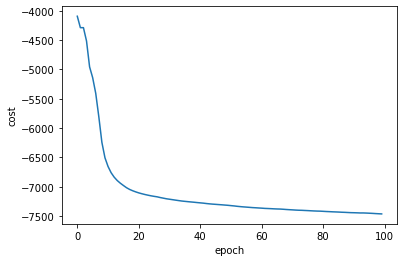

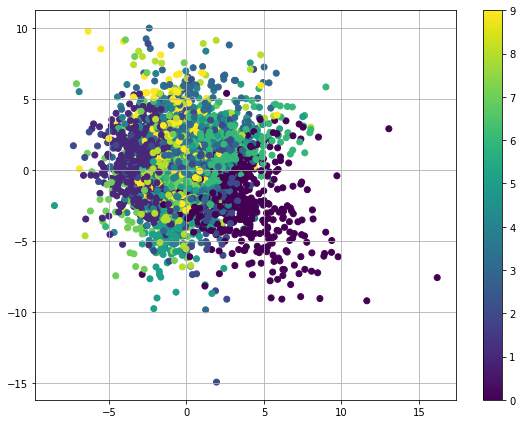

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

y_test = 0
for testX, testY in test_loader:
    x_test = torch.reshape(testX,(10000,784)).double()
    y_test = testY
    
# z dimentsion이 2인 CVAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)


cvae2D = CVariationalAutoEncoder(network_architecture2D)  # latent variable이 2차원이므로 평면에 점을 찍어 나타낼 수 있다.
cvae2D.train(train_loader, batch_size=30000, training_epochs=100, learning_rate=0.001)

y_one_hot = 0
for x_batch, y_batch in test_loader:
    y_batch = y_batch.view(-1, 1)
    one_hot = torch.zeros(10000, 10)
    y_one_hot = one_hot.scatter_(1, y_batch, 1)

cvae2D.plotScatter2D(x_test, y_one_hot, "./log/VAE-2D-Scatter.png")

### Task 3. Generate a synthetic image with a condition
The below code block runs the CVAE to generate an image of your desired number. 

The below code block should not be altered besides of the latent variable position that is the two dimensional list of floats.

<Figure size 432x288 with 0 Axes>

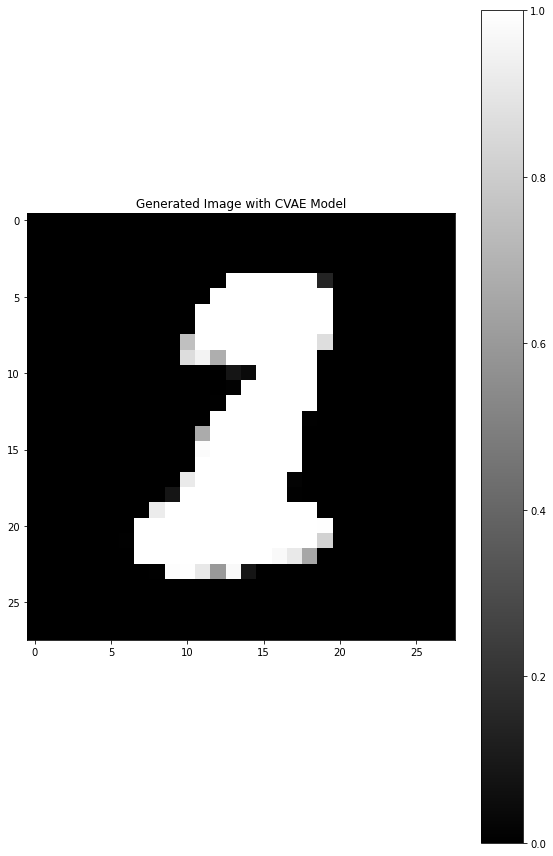

<Figure size 432x288 with 0 Axes>

In [7]:
cvae2D.plotReconstructTest(1,[0,0],'generated.png')